In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd

# Replace 'your_file.csv' with the path to your file
file_path = '/content/drive/My Drive/DataCoSupplyChainDataset.csv'

data = pd.read_csv(file_path,encoding_errors='ignore').head(800)




In [3]:
data.shape

(800, 53)

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LeaveOneOut



# Feature Selection
features = ['Sales per customer', 'Days for shipping (real)', 'Days for shipment (scheduled)',
            'Benefit per order', 'Late_delivery_risk', 'Order Item Discount',
            'Order Item Discount Rate', 'Order Item Product Price', 'Order Item Profit Ratio',
            'Sales', 'Order Item Total', 'Order Profit Per Order', 'Customer Segment',
            'Shipping Mode']

# Numerical Features for Imputation
numerical_features = ['Sales per customer', 'Days for shipping (real)', 'Days for shipment (scheduled)',
                      'Benefit per order', 'Late_delivery_risk', 'Order Item Discount',
                      'Order Item Discount Rate', 'Order Item Product Price', 'Order Item Profit Ratio',
                      'Sales', 'Order Item Total', 'Order Profit Per Order']

In [5]:
# Impute Negative Values
for feature in numerical_features:
    if data[feature].lt(0).any():
        mean_value = data[feature].mean()
        data.loc[data[feature] < 0, feature] = mean_value

# Check for Negative Values
negative_values = data[numerical_features].lt(0).sum()
print("Negative values in each feature:")
print(negative_values)

# Data Preprocessing
data['order_date'] = pd.to_datetime(data['order date (DateOrders)'])
data['year'] = data['order_date'].dt.year
data['month'] = data['order_date'].dt.month
data['day_of_week'] = data['order_date'].dt.dayofweek

X = data[features]
X = pd.get_dummies(X)  # Encode categorical variables
y = data['Order Item Quantity']

Negative values in each feature:
Sales per customer               0
Days for shipping (real)         0
Days for shipment (scheduled)    0
Benefit per order                0
Late_delivery_risk               0
Order Item Discount              0
Order Item Discount Rate         0
Order Item Product Price         0
Order Item Profit Ratio          0
Sales                            0
Order Item Total                 0
Order Profit Per Order           0
dtype: int64


Original dataset shape: Order Item Quantity
1    325
5    201
4    149
3     70
2     55
Name: count, dtype: int64
Resampled dataset shape: [  0 271 271 271 271 271]


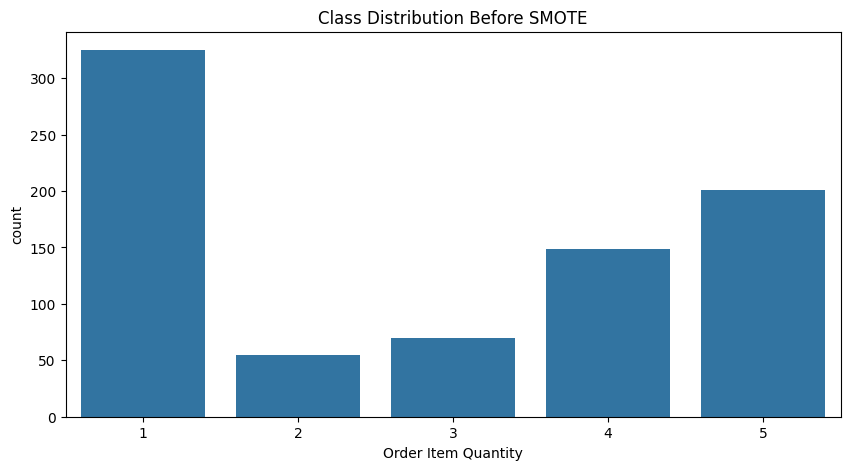

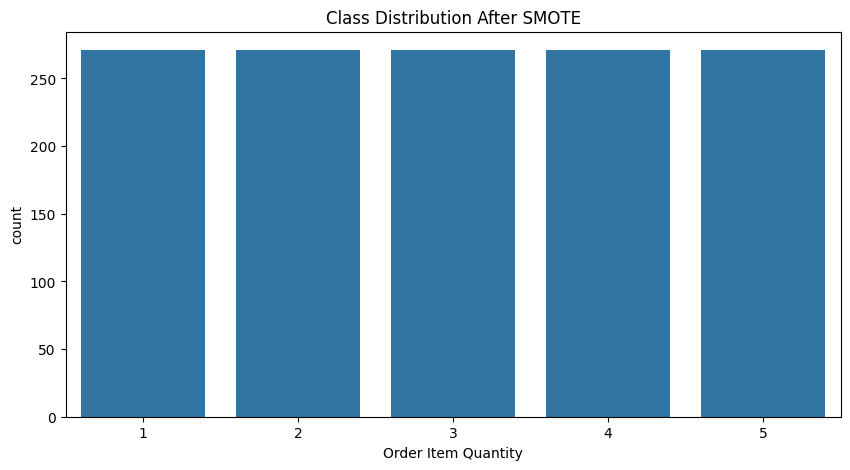

In [6]:
# Split the Data Before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE on Training Data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original dataset shape:", y.value_counts())
print("Resampled dataset shape:", np.bincount(y_train_resampled))

# Visualize Class Distribution Before and After SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(x=y)
plt.title('Class Distribution Before SMOTE')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_resampled)
plt.title('Class Distribution After SMOTE')
plt.show()

In [7]:
# Initialize Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
    "SVM": SVC(C=1.0, probability=True, random_state=42)  # Enable probability estimates for confidence scores
}

In [8]:
# Evaluate Models
for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)
    print("="*60)

Model: Random Forest
Accuracy: 0.7438
Confusion Matrix:
[[54  0  0  0  0]
 [ 1  9  2  0  0]
 [ 0  0 11  1  2]
 [ 0  0  5  8 23]
 [ 0  0  0  7 37]]
Classification Report:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99        54
           2       1.00      0.75      0.86        12
           3       0.61      0.79      0.69        14
           4       0.50      0.22      0.31        36
           5       0.60      0.84      0.70        44

    accuracy                           0.74       160
   macro avg       0.74      0.72      0.71       160
weighted avg       0.74      0.74      0.72       160

Model: Gradient Boosting
Accuracy: 0.9750
Confusion Matrix:
[[54  0  0  0  0]
 [ 0 11  1  0  0]
 [ 0  0 14  0  0]
 [ 0  0  1 33  2]
 [ 0  0  0  0 44]]
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        54
           2       1.00      0.92      0.96        12
    

## Function to plot the learning curve

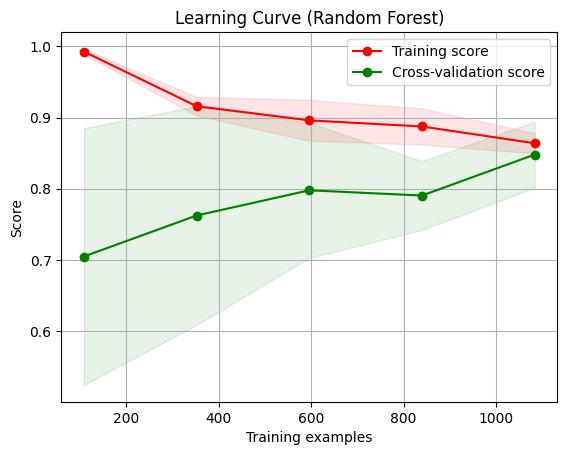

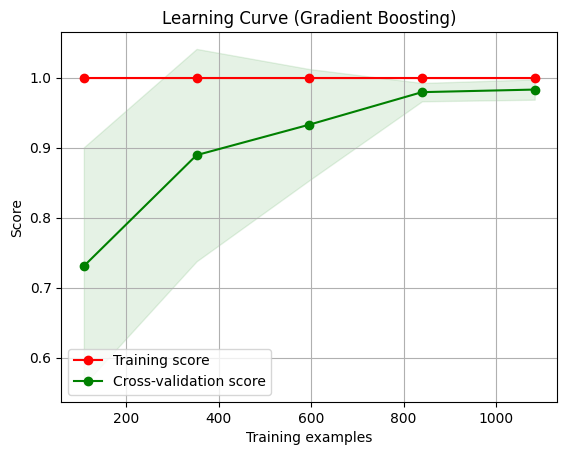

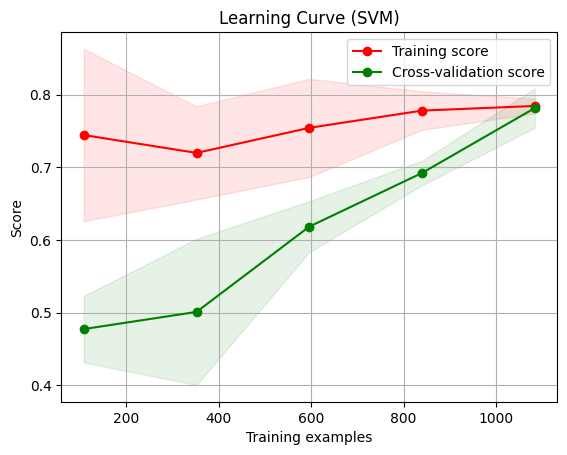

In [9]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
# Example usage: Assuming X_train_resampled and y_train_resampled are defined earlier
for model_name, model in models.items():
    plot_learning_curve(model, f'Learning Curve ({model_name})', X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)
    plt.show()

### ERROR ANALYSIS

In [10]:
def error_analysis(model, X_test, y_test):
    y_pred = model.predict(X_test)
    errors = np.where(y_pred != y_test)[0]
    print(f"Total number of errors: {len(errors)}")
    if len(errors) > 0:
        error_df = pd.DataFrame({'True Label': y_test.iloc[errors].values, 'Predicted Label': y_pred[errors]})
        print(error_df)

    return errors

for model_name, model in models.items():
    print(f"Error Analysis for {model_name}")
    errors = error_analysis(model, X_test, y_test)
    print("="*60)

Error Analysis for Random Forest
Total number of errors: 41
    True Label  Predicted Label
0            5                4
1            4                5
2            3                4
3            5                4
4            5                4
5            4                5
6            4                5
7            4                5
8            4                5
9            4                3
10           5                4
11           2                1
12           3                5
13           4                3
14           2                3
15           5                4
16           3                5
17           4                5
18           4                5
19           4                3
20           4                5
21           4                5
22           2                3
23           4                5
24           4                5
25           4                5
26           4                5
27           4                3
28          

## Function to perform LOOCV and calculate metrics

In [11]:
def perform_loocv(model, X, y):
    loo = LeaveOneOut()
    y_true = []
    y_pred = []
    confidence_scores = []

    iteration = 1
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Make the prediction
        prediction = model.predict(X_test)[0]
        y_pred.append(prediction)
        y_true.append(y_test.values[0])

        # Get the confidence score for the predicted class
        confidence = model.predict_proba(X_test)[0].max()  # Fetching the max probability
        confidence_scores.append(confidence)

        # Print the prediction and confidence score
        print(f"Iteration: {iteration}, True: {y_test.values[0]}, Predicted: {prediction}, Confidence: {confidence:.4f}")
        iteration += 1

    # Calculate the overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    average_confidence = np.mean(confidence_scores)
    std_confidence = np.std(confidence_scores)

    return accuracy, cm, report, average_confidence, std_confidence

print("\nGradient Boosting LOOCV Results:")
gb_accuracy, gb_cm, gb_report, gb_avg_conf, gb_std_conf = perform_loocv(models["Gradient Boosting"], X_train_resampled, y_train_resampled)

# Print Gradient Boosting LOOCV results
print("\nGradient Boosting LOOCV Results")
print(f"LOOCV Accuracy: {gb_accuracy:.4f}")
print("LOOCV Confusion Matrix:")
print(gb_cm)
print("LOOCV Classification Report:")
print(gb_report)
print(f"Average Confidence Score: {gb_avg_conf:.4f}")
print(f"Standard Deviation of Confidence Scores: {gb_std_conf:.4f}")


Gradient Boosting LOOCV Results:
Iteration: 1, True: 1, Predicted: 1, Confidence: 0.9978
Iteration: 2, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 3, True: 2, Predicted: 2, Confidence: 0.9997
Iteration: 4, True: 2, Predicted: 2, Confidence: 0.9997
Iteration: 5, True: 1, Predicted: 1, Confidence: 1.0000
Iteration: 6, True: 3, Predicted: 3, Confidence: 0.9972
Iteration: 7, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 8, True: 2, Predicted: 2, Confidence: 0.9996
Iteration: 9, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 10, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 11, True: 5, Predicted: 5, Confidence: 0.9978
Iteration: 12, True: 5, Predicted: 5, Confidence: 0.9973
Iteration: 13, True: 5, Predicted: 5, Confidence: 0.9979
Iteration: 14, True: 1, Predicted: 1, Confidence: 0.9999
Iteration: 15, True: 4, Predicted: 4, Confidence: 0.9891
Iteration: 16, True: 5, Predicted: 5, Confidence: 0.9959
Iteration: 17, True: 2, Predicted: 2, Confidence: 0.8054
Iterat